# Data Preparation

The following data cleaning steps are done before we conduct our analyses:
- Set the frequency of the dataframe to be the date
- Filter out any unnecessary columns (keeping only y and x variables)
- Interpolate the data so as to fill any missing values in between
- For missing values at the ends of columns, we fill backwards

The final dataframe thus has no missing values and contains only variables used in our analyses.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Covid-19-UK.csv')

# set y to close price
yn = 'Close Price'

# set time index
tn = 'date'

# set freq of df
df.index = pd.to_datetime(df[tn], infer_datetime_format=True)

f = pd.infer_freq(df.index) #frequency specified; might be changed by inference

df.index.freq = f

# filter model variables
filter_fun = lambda x: (x.startswith('cum') or x.startswith('U.S.')) and x != yn
model_vars = list(filter(filter_fun, list(df)))
model_vars.insert(0, yn)

#interpolate missing values in the data
df.interpolate(inplace=True)

#fill rows that are not filled with interpolate() function
for column in df:
    df[column].fillna(method='bfill', inplace=True)
    
#cleaned dataframe
df = df[model_vars]


# Regression Models



We build 2 regression models for our predictions:
- K-Nearest-Neighbour Regression
- Random Forest Regression

The procedure, for each regression model, is as follows:
- Split the data into training and validation sets (80:20 ratio)
- Fit the regression model on the training set
- Predict y values on the validation set and compute MAE and RMSE
- Compare the predictive accuracies of the models using their respective MAE and RMSE when predicting on the validation set. Additionally, do note that we will be using the same training and validation sets for both models so as to maintain consistency in our analysis.

Lastly, we fit both models using the full dataset and output their fit accuracies.


In [2]:
import time
import matplotlib.pyplot as pl
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


y = df[yn]
x = df.iloc[:, 1:]

#split into training & testing sets (80:20 ratio)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

def regression_validate(model, model_name=''):
    
    stm = time.time()

    print('Validating', model_name, 'Regression Model for Predicting Close Price\n')
    print('x-variables: ')
    print(list(x))

    #fit model on training set
    model.fit(x_train, y_train)

    #get fit score
    print('\nAccuracy of  fit     , R² =', model.score(x_train, y_train))
    
    #predict on test set
    predictions = model.predict(x_test)
    
    #get forecast score
    print('Accuracy for forecast, R² =', model.score(x_test, y_test), '\n')
    
    #get prediction error statistics
    print(model_name, 'Validation  MAE = ', mean_absolute_error(y_test, predictions))
    print(model_name, 'Validation RMSE = ', np.sqrt(mean_squared_error(y_test, predictions)))

    #plot y vs y-hat
    pl.rcParams['figure.figsize'] = 7, 7  #square plot

    #plot pseudo regression line
    s, i = np.polyfit(predictions, y_test, 1) #s=slope, i=intercept
    a, b = min(predictions), max(predictions)
    pl.plot([a, b], i + [s * a, s * b], color='red', linewidth=0.4) #increase linewidth for darker line
    del s, i, a, b

    #scatter y vs y-hat
    pl.scatter(predictions, y_test, s = 7, linewidths = 0)
    xn = 'random forest predictions'
    yn = y_test.name
    pl.xlabel(model_name)
    pl.ylabel(yn)
    pl.xticks(rotation=90)
    pl.title("Plot of '" + yn + "' vs '" + model_name + " predictions' for " + str(len(y_test)) + ' obs')
    pl.show()

    print(model_name, 'for', len(x_train), 'rows and', x_train.shape[1], 'columns, and prediction for',
          len(x_test), 'rows took', '%.2f' % ((time.time() - stm)), 'seconds.')

def regression_predict(model, model_name=''):
    
    print('Output', model_name, 'Regression Model for Predicting Close Price\n')
    print('x-variables: ')
    print(list(x))
    
    #fit model on training set
    model.fit(x, y)

    #get fit score
    print('\nAccuracy of  fit     , R² =', model.score(x, y))
    
    return model
    
    

## Predictive Accuracies of Regression Models

### K-Nearest-Neighbours Regression

For the parameters of our K-NN model, we set the number of neighbours to be used as 11 while the distance metric to be used is Euclidean distance. Additionally, predicted values are computed using the weighted average of neighbours' values, with the weights set to be the inverse distance.

Validating K-NN Regression Model for Predicting Close Price

x-variables: 
['cumCasesByPublishDate', 'cumVirusTests', 'cumDailyNsoDeathsByDeathDate', 'cumPeopleVaccinatedCompleteByPublishDate', 'cumAdmissions', 'U.S. cases', 'U.S. deaths']

Accuracy of  fit     , R² = 0.9998236862857485
Accuracy for forecast, R² = 0.9523948959687351 

K-NN Validation  MAE =  66.26166239864865
K-NN Validation RMSE =  116.81588364851807


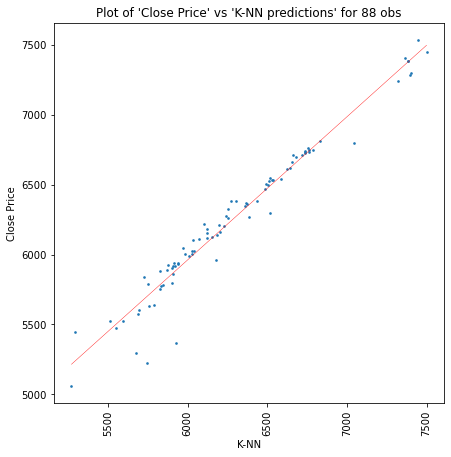

K-NN for 351 rows and 7 columns, and prediction for 88 rows took 0.21 seconds.


In [3]:
regression_validate(KNeighborsRegressor(11, weights='distance'), 'K-NN')

### Random Forest Regression

Validating Random Forest Regression Model for Predicting Close Price

x-variables: 
['cumCasesByPublishDate', 'cumVirusTests', 'cumDailyNsoDeathsByDeathDate', 'cumPeopleVaccinatedCompleteByPublishDate', 'cumAdmissions', 'U.S. cases', 'U.S. deaths']

Accuracy of  fit     , R² = 0.9973349467620259
Accuracy for forecast, R² = 0.9878445723139974 

Random Forest Validation  MAE =  39.14367377976161
Random Forest Validation RMSE =  59.02829801848028


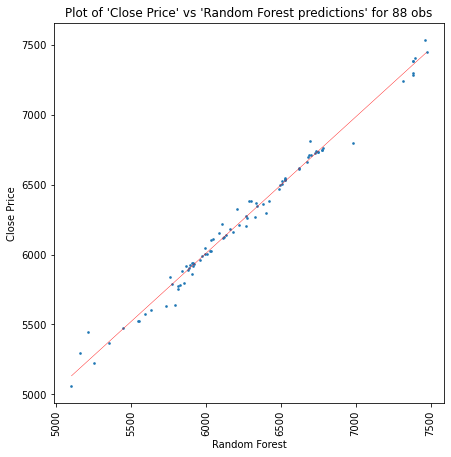

Random Forest for 351 rows and 7 columns, and prediction for 88 rows took 0.47 seconds.


In [4]:
regression_validate(RandomForestRegressor(), 'Random Forest')

### Regression Model Comparison

Upon analysing the fit statistics of both regression models, we can see that the adjusted $R^{2}$ of fit for the K-NN Regression model is slightly higher than that of the Random Forest Regression Model. However, when comparing their forecast statistics, it is evident that the Random Forest Model has a higher adjusted $R^{2}$ of forecast and a lower MAE and RMSE when predicting on the validation set, as compared to the K-NN model.

This thus shows that the K-NN model actually overfits on the data, and that the Random Forest model is more accurate in predicting FTSE100 Close Prices.

In conclusion, we select the Random Forest model over the K-NN model due to its superior predictive accuracy.

Nonetheless, we built both regression models, fitted on the full dataset, and included them below.

## Output Final Regression Models

In [5]:
model_knn = regression_predict(KNeighborsRegressor(11, weights='distance'), 'K-NN')
print('\n')
model_randomforest = regression_predict(RandomForestRegressor(), 'Random Forest')

Output K-NN Regression Model for Predicting Close Price

x-variables: 
['cumCasesByPublishDate', 'cumVirusTests', 'cumDailyNsoDeathsByDeathDate', 'cumPeopleVaccinatedCompleteByPublishDate', 'cumAdmissions', 'U.S. cases', 'U.S. deaths']

Accuracy of  fit     , R² = 0.9995448706506639


Output Random Forest Regression Model for Predicting Close Price

x-variables: 
['cumCasesByPublishDate', 'cumVirusTests', 'cumDailyNsoDeathsByDeathDate', 'cumPeopleVaccinatedCompleteByPublishDate', 'cumAdmissions', 'U.S. cases', 'U.S. deaths']

Accuracy of  fit     , R² = 0.9975756615960388


# Time Series Models

We build 2 time series models for our predictions:
- Winters' Forecast
- ARIMAX

The procedure, for each time series model, is as follows:
- Leave out the last 7 days to be forecasted
- Fit the model on all the previous data (excluding last 7 days)
- Predict the last 7 days' y values using the fitted model and compute MAE and RMSE
- Compare the predictive accuracies of the models using their respective MAE and RMSE when predicting on the last 7 days' values

Lastly, we predict the next 7 days values using the model with higher predictive accuracy.

In [38]:
#leave last 7 tail periods blank in y column (for forecasting)
y_to_forecast = y.iloc[-7:].copy()
y_to_forecast_list = list(y_to_forecast)
print('last 7 close prices to be forecasted:\n ', y_to_forecast, '\n')

#save y column first
y_original = y.copy()

for x in list(y_to_forecast):
    df[yn].replace({x: ""}, inplace=True) 

#done preparing time series

pc = 7 #periodicity

n0 = int(y.count()) #number of non-Nan values; type(df[yn].count())=<class 'numpy.int32'>
n2 = len(df) - n0 #periods to forecast ahead
n2 = pc if n2 == 0 else n2
n = min(3653, n0) #use only the last 3653 observations
if n != n0:
    print('Only the last', n, 'of', n0, 'observations will be used for fitting.\n')
n1 = min(len(y), n + n2)
y = y[-n1:-n2] #last 10 rows have no row labels
x =  df.iloc[-n1:-n2, 1:] #for fitting in-sample values
x2 = df.iloc[-n2:, 1:] #for forecasting future values
xc = x.shape[1] #number of X variables

stnd = pd.date_range(y.index[-1], periods=n2+1, freq=y.index.freq)


last 7 close prices to be forecasted:
  date
2021-03-28    6737.643333
2021-03-29    6736.170000
2021-03-30    6772.120000
2021-03-31    6713.630000
2021-04-01    6737.300000
2021-04-02    6737.300000
2021-04-03    6737.300000
Freq: D, Name: Close Price, dtype: float64 



## Model Validation - Winters' Forecast

We first decompose the time series to better understand underlying trend, seasonality and noise in the data. 

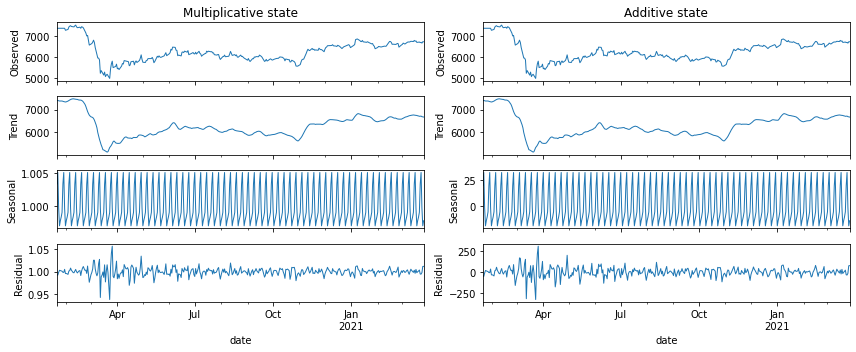

RMSE Mul: 32.115593769808356
RMSE Add: 32.15636449315857


In [42]:
pl.rcParams['figure.figsize'] = 18, 8
import statsmodels.api as sm

res_m = sm.tsa.seasonal_decompose(y, model='mul', period=7, extrapolate_trend='freq' )

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')


res_a = sm.tsa.seasonal_decompose(y, model='add', period=7, extrapolate_trend='freq')

fig, axes = pl.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

cols = ['{} state'.format(col) for col in ('Multiplicative','Additive')]
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

    
plotseasonal(res_m, axes[:,0])
plotseasonal(res_a, axes[:,1])

pl.tight_layout()
pl.show()

#compare rmse
p=7
o = ExponentialSmoothing(y.astype('float'), freq=y.index.freq, trend='add', seasonal='mul' , seasonal_periods=7).fit().forecast(p)
errs = o - y_to_forecast_list
print('RMSE Mul:', np.sqrt((errs ** 2).mean()))

o = ExponentialSmoothing(y.astype('float'), freq=y.index.freq, trend='add', seasonal='add' , seasonal_periods=7).fit().forecast(p)
errs = o - y_to_forecast_list
print('RMSE Add:', np.sqrt((errs ** 2).mean()))

There seems to be not much difference in the seasonality and trend by the decomposition, and since RMSE for multiplicative is marginally better, we use a multiplicative seasonality for Winters' Forecast.

We fit the Winters' Forecast model on the FTSE100 Close Price time series from 2020-01-21 to 2021-03-27. Then, we forecast the values for 2021-03-28 to 2021-04-03 to evaluate the predictive accuracy of the model.



 
Winters' Forecast:  

                       ExponentialSmoothing Model Results                       
Dep. Variable:              Close Price   No. Observations:                  432
Model:             ExponentialSmoothing   SSE                        2508408.309
Optimized:                         True   AIC                           3766.029
Trend:                         Additive   BIC                           3810.782
Seasonal:                Multiplicative   AICC                          3766.900
Seasonal Periods:                     7   Date:                 Sat, 24 Apr 2021
Box-Cox:                          False   Time:                         18:14:39
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950000                alpha                 True

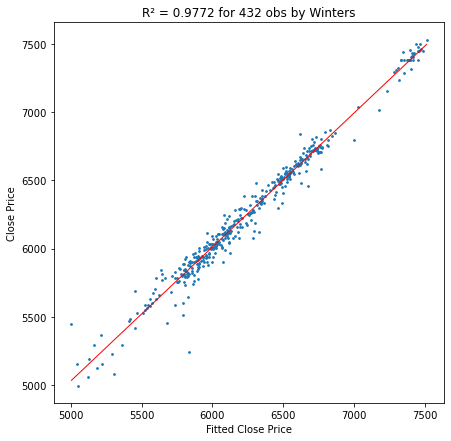


Forecasted vs Actual values for last 7 days:
               Forecast       Actual  Difference
2021-03-28  6737.746905  6737.643333    0.103571
2021-03-29  6734.539058  6736.170000   -1.630942
2021-03-30  6751.811153  6772.120000  -20.308847
2021-03-31  6761.470196  6713.630000   47.840196
2021-04-01  6720.147446  6737.300000  -17.152554
2021-04-02  6692.691162  6737.300000  -44.608838
2021-04-03  6690.056834  6737.300000  -47.243166

MAE:   25.555444811783023
RMSE:  32.115593769808356


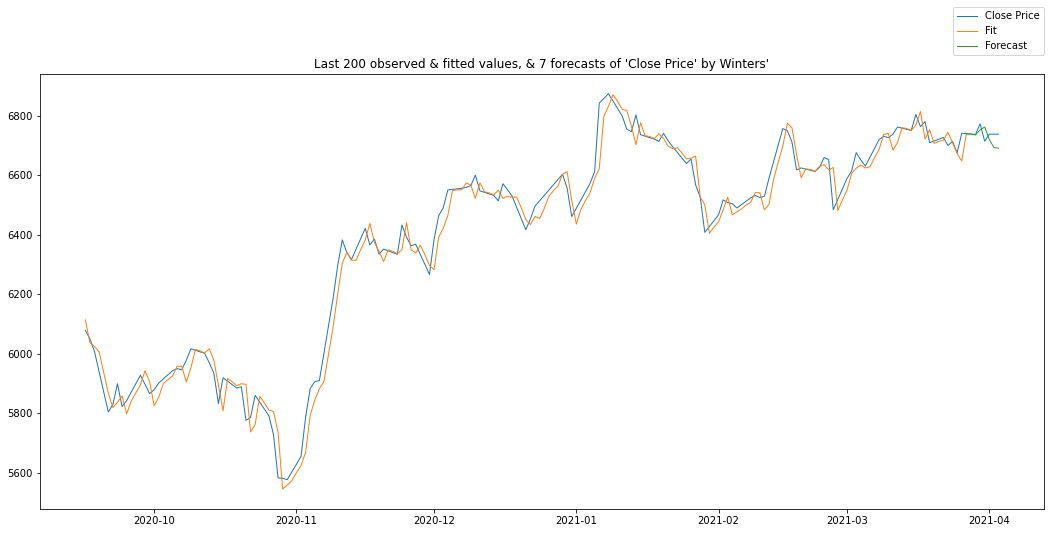

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

from statsmodels.tsa.api import ExponentialSmoothing

def winters(validating=False):

    pl.rcParams['figure.figsize'] = 18, 8
    pl.rcParams['lines.linewidth'] = 1
    pl.rcParams['lines.markersize'] = 1

    o = ExponentialSmoothing(y.astype('float'), freq=y.index.freq, trend='add', seasonal='mul', seasonal_periods=7).fit()
    p = 7

    print(2 * '\n', f'\033[1m')
    print("Winters' Forecast:", f'\033[0m', '\n')
    print(o.summary())

    #fit model
    fits = o.fittedvalues

    yh = pd.concat((y.astype(float), fits.rename('Fitted')), 1) #y & yhat
    print(yh)

    #plot time series vs fit and its 'line'

    #plot 'regression' line
    mm = np.array([min(fits), max(fits)], dtype=np.float)
    y0 = y[len(y)-len(fits):].astype(float) if validating else y#y & ft can have different lengths

    pl.rcParams['figure.figsize'] = 7, 7 #square plot

    pl.plot(mm, sum(np.polyfit(fits, y0, 1) * [mm, 1]), 'r', lw=1) #increase linewidth for darker line

    #scatter time series vs fit

    pl.scatter(fits, y0, s=3)

    pl.ylabel(yn)
    pl.xlabel('Fitted ' + yn)
    pl.title('R² = ' + str('%.4f' % yh.corr().iloc[1,0]**2) + ' for ' + str(len(y0)) +
             ' obs by Winters')
    pl.show()
    
    #Winters' forecast for last 7 days
    forecasts = o.forecast(p)
    
    if validating:
    
        #compute diffs between forecasts vs actual
        errs = forecasts - y_to_forecast_list

        f = pd.concat([fits, forecasts], axis=0)

        print('\nForecasted vs Actual values for last 7 days:')
        print(pd.concat((forecasts, y_to_forecast, errs), 1, keys=['Forecast', 'Actual', 'Difference']))


        print('\nMAE:  ', abs(errs).mean())
        print('RMSE: ', np.sqrt((errs ** 2).mean()))
        
    else:
        
        print('\nForecasted values for next 7 days:')
        print(forecasts)
        
        
    #plot last 200 values (including forecasts)
    
    pl.rcParams['figure.figsize'] = 18, 8 #use the whole width of window

    pl.title('Last 200 observed & fitted values, & ' + str(p) + " forecasts of '"
             + yn + "' by Winters'")
    pl.plot(y_original[-200:], label = yn)
    pl.plot(fits[p-200:], label = 'Fit') if validating else pl.plot(fits[-200:], label = 'Fit')
    pl.plot(pd.concat((fits.iloc[len(fits) - 1:], forecasts)), label = 'Forecast')
    pl.legend(bbox_to_anchor=(1.005, 1.165))
    pl.show()
    
winters(validating=True)


## Model Validation - ARIMAX

Similarly, we fit an ARIMAX model on the FTSE100 Close Price time series from 2020-01-21 to 2021-03-27. Then, we forecast the values for 2021-03-30 to 2021-04-03 to evaluate the predictive accuracy of the model.

The exogenous variables used are the same as the one used in our regression models. That is, the cumulative number of cases, deaths, vaccinations and virus tests in the UK, as well as the cumulative number of deaths and cases in the US.

As for the model parameters, we will be combining a 1st order Auto-Regressive model and a 1st order Moving Average model.

### Stationarity
We first conduct a hypothesis test at a 5% level of significance to determine whether the time series is stationary. If the model is stationary, then no differencing would be required, and vice versa.

In [9]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(y)

#H0: It is non stationary
#H1: It is stationary

def adfuller_test(closeprice):
    result=adfuller(closeprice)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of observations used']
    for value, label in zip(result, labels):
        print(label + ':' + str(value), '\n')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('Weak evidence against null hypothesis(H0), time series has a unit root, indicating it is non-stationary.')
    
adfuller_test(y)


ADF Test Statistic:-2.8079316392241305 

p-value:0.05714969144929082 

#Lags Used:13 

Number of observations used:418 

Weak evidence against null hypothesis(H0), time series has a unit root, indicating it is non-stationary.


#### Interpretation:

Since the data is non-stationary, differencing is needed for the ARIMAX mdoel. 

For ARIMAX modelling:

p: The number of lag observations included in the model, also called the lag order. (AR)

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average. (MA)


### Determining the parameters (p,d,q) for ARIMAX modelling
We will be comparing the 1st and 2nd differencing to determine the value of d. To determine p, Partial Autocorrelation (PACF) plot will be used. To determine q, Autocorrelation plot (ACF) will be used.

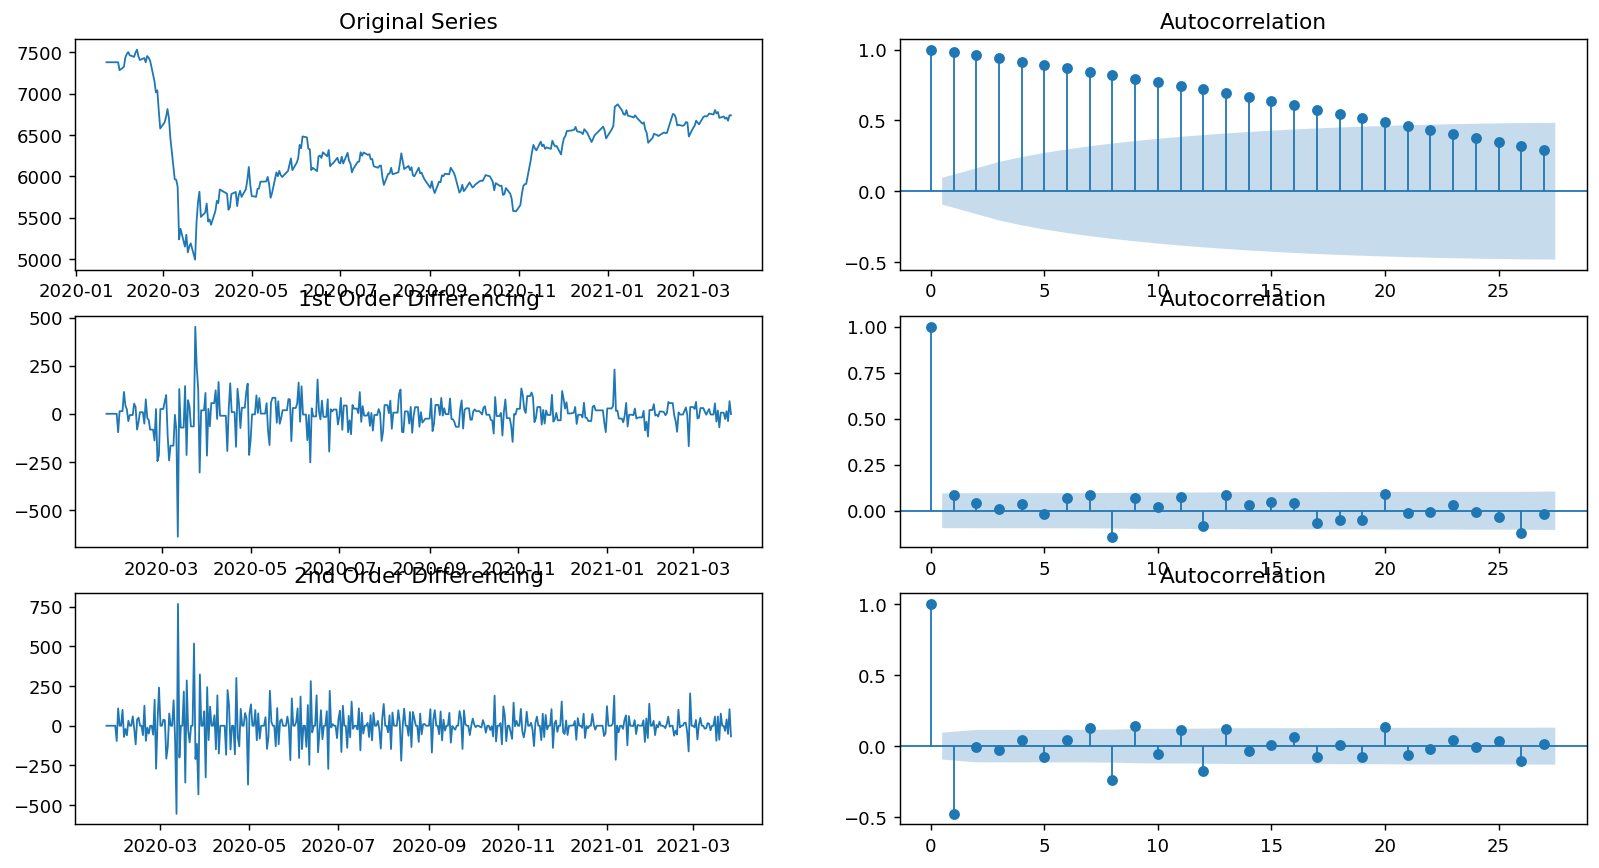

In [10]:
# Comparing differencing values to determine 'd' in (p,d,q)

data = df[yn][1:-7]

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pl.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':130})

# Original Series
fig, axes = pl.subplots(3, 2, sharex=False)
axes[0, 0].plot(data); axes[0, 0].set_title('Original Series')
plot_acf(data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.diff().diff().dropna(), ax=axes[2, 1])

pl.show()

#### Interpretation:

For the above series, the time series reaches stationarity with one order of differencing. Looking at the autocorrelation plot for the 2nd differencing, the lag goes into the negative zone fairly quickly, which indicates that the series is over-differenced.
Hence, we fit d=1.

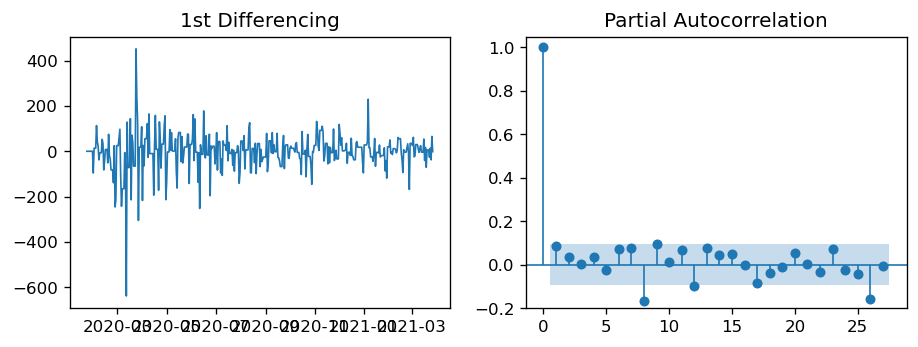

In [11]:
# PACF plot of 1st differenced series
pl.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = pl.subplots(1, 2, sharex=False)
axes[0].plot(data.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-0.2,1.05))
plot_pacf(data.diff().dropna(), ax=axes[1])

pl.show()

#### Interpretation:

The PACF lag 1 is quite significant since it is above the significance line (blue region). Hence, we fix p=1.

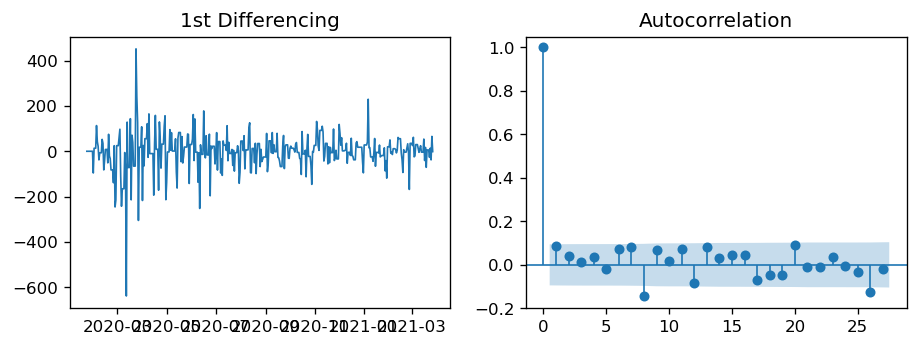

In [12]:
fig, axes = pl.subplots(1, 2, sharex=False)
axes[0].plot(data.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-0.2,1.05))
plot_acf(data.diff().dropna(), ax=axes[1])

pl.show()

#### Interpretation:

The ACF lag 1 is quite significant since it is above the significance line (blue region). Hence, we fix q=1.

### Fitting the ARIMAX Model
The following model parameters are used:
- p = 1 (1st order auto-regressive model)
- d = 1 (differencing of 1)
- q = 1 (1st order moving average model)


Fitting ARIMAX(1,1,1) for the last 432 obs of 'Close Price' using 7 X-variables: ['cumCasesByPublishDate', 'cumVirusTests', 'cumDailyNsoDeathsByDeathDate', 'cumPeopleVaccinatedCompleteByPublishDate', 'cumAdmissions', 'U.S. cases', 'U.S. deaths']...

                             ARIMA Model Results                              
Dep. Variable:          D.Close Price   No. Observations:                  431
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2484.234
Method:                       css-mle   S.D. of innovations             77.088
Date:                Sat, 24 Apr 2021   AIC                           4990.469
Time:                        18:14:42   BIC                           5035.196
Sample:                    01-22-2020   HQIC                          5008.129
                         - 03-27-2021                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------

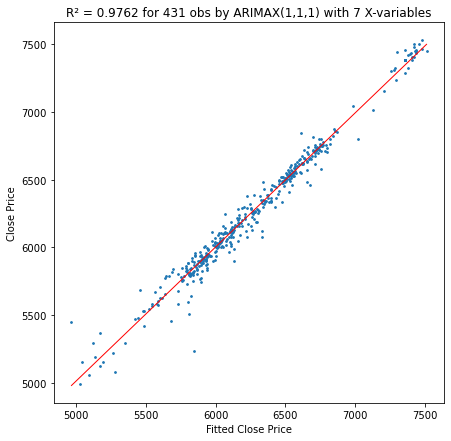

StdErr(Fitted) = 77.08753613624914 (same as for 1st forecast value below)




In [13]:
#fit ARIMA to time series

import matplotlib.pyplot as pl
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

#p rep. AR model lags, d rep. differencing, q rep. MA lags
p, d, q = 1, 1, 1
print(f'\033[1m' + '\nFitting ARIMA' + ('X' if xc > 0 else '') + '(' + str(p) + ',' + str(d) + ',' + str(q)
      + ') for the last', len(y), "obs of '" + yn + ("' using " + str(xc) + ' X-variables: '
                                             + str(list(x)) if xc > 0 else "'")
      + '...\n' + f'\033[0m') #in bold

from statsmodels.tsa.arima_model import ARIMA

out = ARIMA(y.astype(float), (p,d,q), x.astype(float)).fit() if xc > 0 else ARIMA(y.astype(float), (p,d,q)).fit()

print(out.summary(), '\n')

ft = out.predict(typ='levels') #without 'levels', fitted output will be for d-differenced series
yh = pd.concat((y.astype(float), ft.rename('Fitted')), 1) #y & yhat
print(yh)

#plot time series vs fit and its 'line'

#plot 'regression' line
mm = np.array([min(ft), max(ft)], dtype=np.float)
y0 = y[len(y)-len(ft):].astype(float) #y & ft can have different lengths

pl.rcParams['figure.figsize'] = 7, 7 #square plot

pl.plot(mm, sum(np.polyfit(ft, y0, 1) * [mm, 1]), 'r', lw=1) #increase linewidth for darker line

#scatter time series vs fit

pl.scatter(ft, y0, s=3)

pl.ylabel(yn)
pl.xlabel('Fitted ' + yn)
pl.title('R² = ' + str('%.4f' % yh.corr().iloc[1,0]**2) + ' for ' + str(len(y0)) +
         ' obs by ARIMA' + ('X(' if xc > 0 else '(') + str(p) + ',' + str(d) + ','
         + str(q) + ')' + (' with ' + str(xc) + ' X-variables' if xc > 0 else ''))
pl.show()

print('StdErr(Fitted) =', np.sqrt(out.sigma2), '(same as for 1st forecast value below)' '\n\n')


### ARIMAX Forecast for Last 7 Days

Forecasting 7 future values of 'Close Price' using 7 X-variables...

               Forecast       Actual  Difference   Std Error
2021-03-28  6720.844814  6737.643333  -16.798519   77.087536
2021-03-29  6697.880991  6736.170000  -38.289009  112.633373
2021-03-30  6666.738799  6772.120000 -105.381201  139.488628
2021-03-31  6625.325148  6713.630000  -88.304852  161.952959
2021-04-01  6568.354505  6737.300000 -168.945495  181.660324
2021-04-02  6502.336768  6737.300000 -234.963232  199.429653
2021-04-03  6430.349958  6737.300000 -306.950042  215.740353

MAE:   137.09033564675687
RMSE:  168.44660527042615


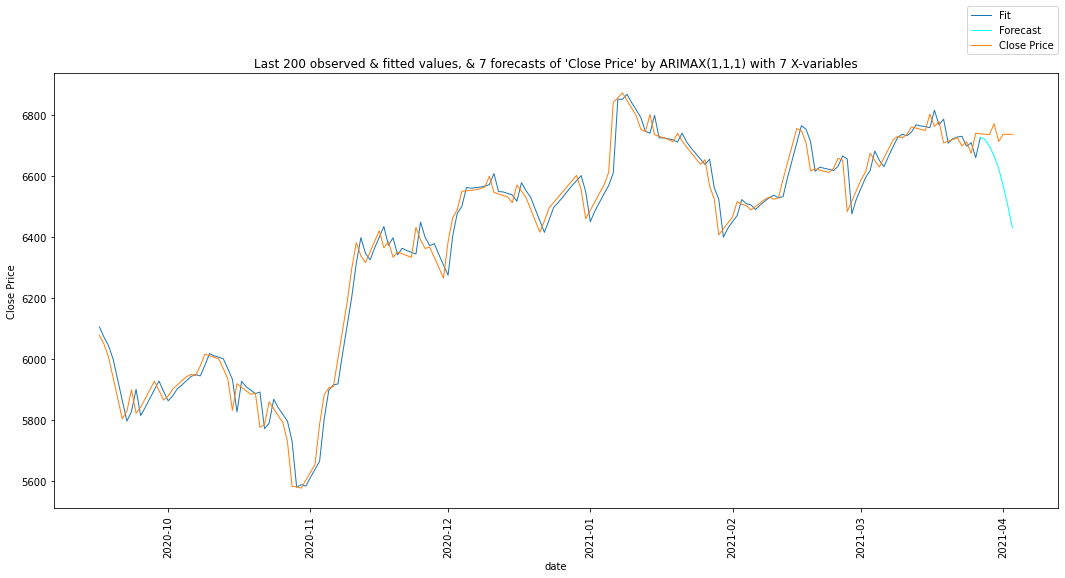

In [14]:
#forecast last 7 days

stnd = pd.date_range(y.index[-1], periods=n2+1, freq=y.index.freq)
print(f'\033[1m' + 'Forecasting', n2, "future values of '" + yn
      + ("' using " + str(xc) + ' X-variables' if xc > 0 else "'") + '...\n' + f'\033[0m')

fc, stderr, confint = out.forecast(n2, x2) if xc > 0 else out.forecast(n2)

print(pd.concat((pd.Series(fc), pd.Series(y_to_forecast_list), 
                 pd.Series(fc - y_to_forecast_list), pd.Series(stderr)), 
                1, keys=['Forecast', 'Actual', 'Difference', 'Std Error']
               ).set_index(stnd[1:]))

errs = fc - y_to_forecast_list


fc = pd.Series(fc, index=pd.date_range(ft.index[-1], periods=len(fc)+1,
                                    freq=ft.index.freq)[1:]).rename('Forecast')

errs = fc - y_to_forecast_list

print('\nMAE:  ', abs(errs).mean())
print('RMSE: ', np.sqrt((errs ** 2).mean()))

#plot last 200 training periods' observed & fitted, & forecast

pl.rcParams['figure.figsize'] = 18, 8 #use the whole width of window

pl.title('Last 200 observed & fitted values, & ' + str(n2) + " forecasts of '"
         + yn + "' by ARIMA" + ('X(' if xc > 0 else '(') + str(p) + ',' + str(d) + ','
         + str(q) + ')' + (' with ' + str(xc) + ' X-variables' if xc > 0 else ''))
pl.plot(ft[-193:], label='Fit')
pl.plot(ft[-1:].append(fc), c='cyan', label=fc.name)

pl.plot(y_original[-200:], label=yn)

pl.legend(bbox_to_anchor=(1.005, 1.165))

pl.xticks(rotation=90)
pl.xlabel(y.index.name)
pl.ylabel(yn)
pl.show()


Comparing the actual and forecasted values, the forecasted values are lower than the actual values in all cases.
The plot also clearly shows that forecasts follow a much steeper decreasing trend than the actual values.

## Time Series Model Comparison

Upon analysing the fit statistics of both time series models, we can see that the adjusted $R^{2}$ of fit for both models are approximately equal. However, when comparing their forecast statistics, it is evident that the Winters' Forecast Model has a lower MAE and RMSE when predicting the last 7 days' values, as compared to the ARIMAX model.

This thus shows that the ARIMAX model actually overfits on the data, and that the Winters' Forecast model is more accurate in predicting FTSE100 Close Prices.

In conclusion, we select the Winters' Forecast model over the ARIMAX model due to its superior predictive accuracy.

## Predict Next 7 Days with Winters' Forecast

The Winters' Forecast model had a higher predictive accuracy as compared to the ARIMAX model. Thus, we use it to predict the next 7 days' FTSE100 Close Price values as shown below.



 
Winters' Forecast:  

                       ExponentialSmoothing Model Results                       
Dep. Variable:              Close Price   No. Observations:                  439
Model:             ExponentialSmoothing   SSE                        2569609.669
Optimized:                         True   AIC                           3830.222
Trend:                         Additive   BIC                           3875.151
Seasonal:                      Additive   AICC                          3831.078
Seasonal Periods:                     7   Date:                 Sat, 24 Apr 2021
Box-Cox:                          False   Time:                         18:14:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9381405                alpha                 True

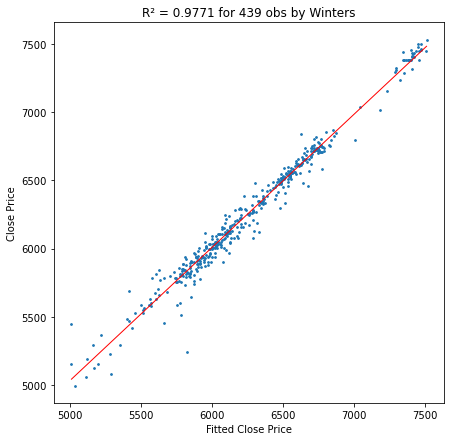


Forecasted values for next 7 days:
2021-04-04    6743.139760
2021-04-05    6748.577092
2021-04-06    6766.785158
2021-04-07    6780.709867
2021-04-08    6767.318904
2021-04-09    6749.948003
2021-04-10    6755.006583
Freq: D, dtype: float64


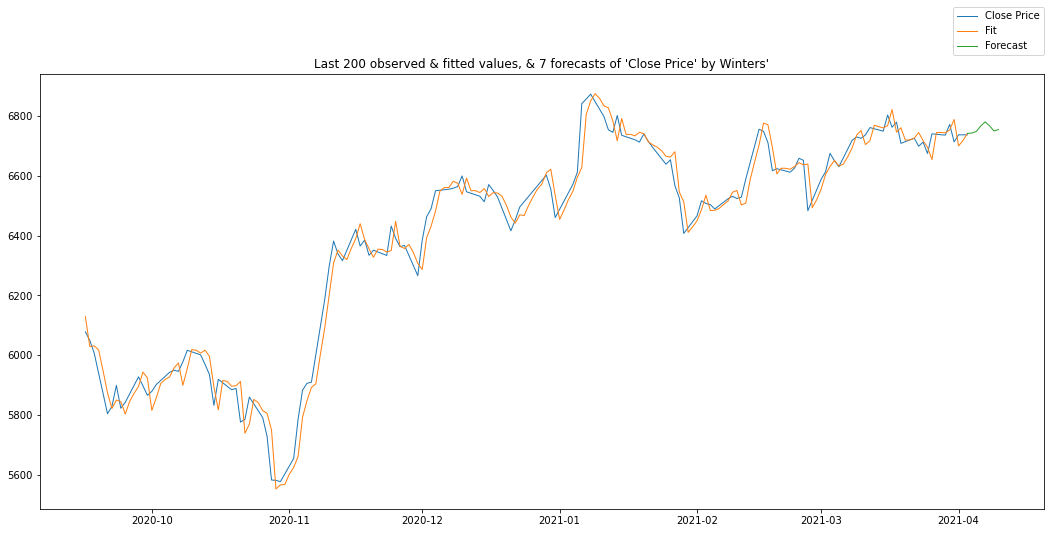

In [15]:
y = y_original

winters(validating=False)

As can be seen, the trend predicted for the next 7 days is as follows:
- Close prices will decrease from 4th to 5th April
- It will then increase from 5th to 7th April
- Finally, it will decrease steadily 7th to 10th April

Overall, the predicted values show a decreasing trend from 4th to 10th April.